In [1]:
from google.colab import drive
import os

# drive.mount('/content/gdrive')
os.chdir('./gdrive/MyDrive/Project')

In [2]:
ls

architecture.py  first.ipynb  predict.ipynb  utils.py
Dataset/         model1/      __pycache__/


In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchsummary import summary
# !pip install torchviz
from architecture import Architecture
from utils import train, plot
import pickle as pkl
import shutil

torch.manual_seed(0)

In [4]:
min_images = 20
max_images = 200
image_shape = (64, 64)
num_channels = 1

transform = torchvision.transforms.Compose([
    torchvision.io.read_image,
    torchvision.transforms.functional.rgb_to_grayscale,
    torchvision.transforms.Resize(size = image_shape),
])

# transform = torchvision.transforms.Compose([
#     torchvision.io.read_image,
#     torchvision.transforms.Resize(size = image_shape),
# ])

In [5]:
dataset = './Dataset/lfw_funneled/'
names = []
for name in os.listdir(dataset):
    if len(os.listdir(dataset+name)) >= min_images:
        names.append(name)

train_images, val_images, train_labels, val_labels = [], [], [], []

for i,name in enumerate(names):
    imgs = [dataset+name+'/'+img for img in os.listdir(dataset+name)]
    imgs = [imgs[i] for i in torch.randperm(len(imgs))[:max_images]]
    lbls = [i for img in imgs]
    imgs1, imgs2, lbls1, lbls2 = train_test_split(imgs, lbls, random_state=42, test_size=0.2)
    train_images += imgs1
    val_images += imgs2
    train_labels += lbls1
    val_labels += lbls2

print(f'Train Data size : {len(train_images)}\nValidation Data size : {len(val_images)}')

Train Data size : 1081
Validation Data size : 281


In [6]:
modelname = 'model2'
if os.path.exists(f'./{modelname}/'):
  shutil.rmtree(f'./{modelname}')
os.mkdir(f'./{modelname}')

pkl.dump(names, open(f'./{modelname}/names.pkl', 'wb'))

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, labels, transform):
        super().__init__()
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = self.transform(self.img_paths[idx])
        label = torch.zeros(len(names))
        label[self.labels[idx]] = 1
        return (image, label)

In [8]:
train_ds = MyDataset(train_images, train_labels, transform)
val_ds = MyDataset(val_images, val_labels, transform)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

arct_args = {
    'image_shape': (2, num_channels, *image_shape),
    'in_ch1': num_channels,
    'out_ch1': 64,
    'in_ch2': 256,
    'out_ch2': len(names),
    'layer1': 2,
    'layer2': 1,
    'layer3': 2,
    'arct_name': modelname
}

arct = Architecture(arct_args).to(device)
print(summary(arct, (num_channels, *image_shape)))
print(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]             640
              ReLU-2           [-1, 64, 62, 62]               0
       BatchNorm2d-3           [-1, 64, 62, 62]             128
            Conv2d-4           [-1, 64, 60, 60]          36,928
              ReLU-5           [-1, 64, 60, 60]               0
       BatchNorm2d-6           [-1, 64, 60, 60]             128
            Conv2d-7           [-1, 64, 60, 60]          36,928
              ReLU-8           [-1, 64, 60, 60]               0
       BatchNorm2d-9           [-1, 64, 60, 60]             128
        MaxPool2d-10           [-1, 64, 30, 30]               0
          Dropout-11           [-1, 64, 30, 30]               0
           Layer1-12           [-1, 64, 30, 30]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
             ReLU-14          [-1, 128,

In [10]:
train_args = {
    'epochs': 50,
    'batch_size': 16,
    'learning_rate': 0.001,
    'momentum': 0.4,
    'device': device,
    'save': True,
    'output': True,
    'arct_name': modelname,
    'weight_decay': 0.01
}

H = train(arct, train_ds, val_ds, train_args)

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 1/50
Train loss: 3.1279, Val loss: 3.1306,
Train Accuracy: 0.0870, Val Accuracy: 0.07829
EPOCH: 2/50
Train loss: 3.0465, Val loss: 2.9533,
Train Accuracy: 0.1730, Val Accuracy: 0.2669
EPOCH: 3/50
Train loss: 2.9068, Val loss: 2.8075,
Train Accuracy: 0.3053, Val Accuracy: 0.4128
EPOCH: 4/50
Train loss: 2.7850, Val loss: 2.8072,
Train Accuracy: 0.4283, Val Accuracy: 0.4021
EPOCH: 5/50
Train loss: 2.7184, Val loss: 2.7014,
Train Accuracy: 0.4995, Val Accuracy: 0.516
EPOCH: 6/50
Train loss: 2.6427, Val loss: 2.7004,
Train Accuracy: 0.5698, Val Accuracy: 0.5196
EPOCH: 7/50
Train loss: 2.5643, Val loss: 2.6430,
Train Accuracy: 0.6522, Val Accuracy: 0.5765
EPOCH: 8/50
Train loss: 2.5415, Val loss: 2.5653,
Train Accuracy: 0.6772, Val Accuracy: 0.6512
EPOCH: 9/50
Train loss: 2.4979, Val loss: 2.6410,
Train Accuracy: 0.7160, Val Accuracy: 0.5658
EPOCH: 10/50
Train loss: 2.4879, Val loss: 2.5652,
Train Accuracy: 0.7216, Val Accuracy: 0.6512
EPOCH: 11/50
Train loss: 2.4674, Val loss: 2.5418

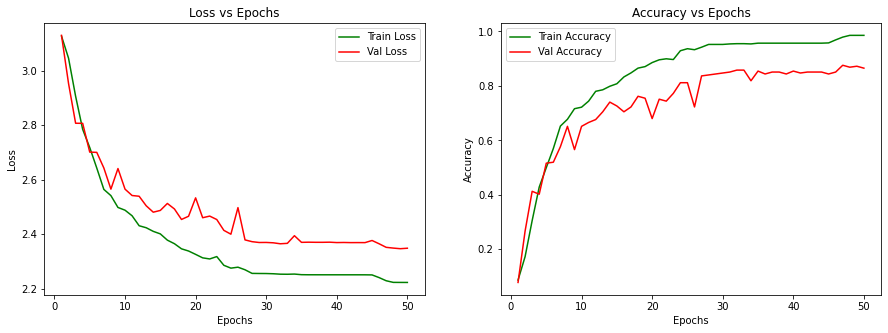

In [11]:
plot(H, train_args)